<a href="https://colab.research.google.com/github/Sakku0saq/Gravity_Simulation_Cpp/blob/master/ADAGRAD_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install nnfs

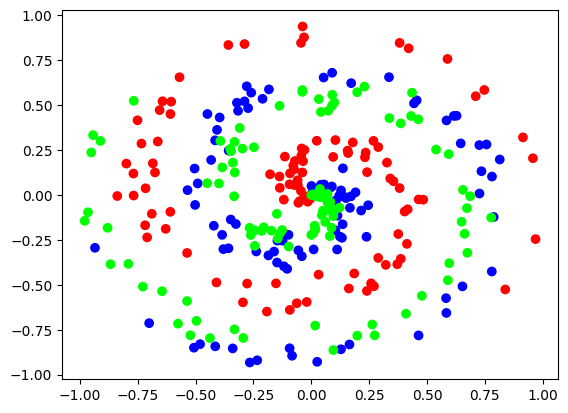

In [4]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()
import matplotlib.pyplot as plt
X,y=spiral_data(samples=100,classes =3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

In [5]:
#Dense Layer Class
class Layer_Dense:
  #Layer initialization
  def __init__(self,n_inputs,n_neurons):
    self.weights=0.01*np.random.rand(n_inputs,n_neurons)
    self.biases=np.zeros((1,n_neurons))

  #Forward Pass
  def forward(self,inputs):
    #Remember inputs values
    self.inputs=inputs
    self.output=np.dot(inputs,self.weights)+self.biases

  #Backward Pass
  def backward(self,dvalues):
    self.dweights=np.dot(self.inputs.T,dvalues)
    self.dbias=np.sum(dvalues,axis=0,keepdims=True)
    self.dinputs=np.dot(dvalues,self.weights.T)

In [6]:
#ReLU Activation
class Activation_ReLU:

    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.maximum(0,inputs)

    def backward(self,dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0

In [7]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

In [8]:
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

In [9]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
 # Forward pass
 def forward(self, y_pred, y_true):
  # Number of samples in a batch
  samples = len(y_pred)
  # Clip data to prevent division by 0
  # Clip both sides to not drag mean towards any value
  y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
  # Probabilities for target values -
  # only if categorical labels
  if len(y_true.shape) == 1:
   correct_confidences = y_pred_clipped[
   range(samples),
   y_true
   ]
  # Mask values - only for one-hot encoded labels
  elif len(y_true.shape) == 2:
   correct_confidences = np.sum(
   y_pred_clipped*y_true,
   axis=1
   )
 # Losses
  negative_log_likelihoods = -np.log(correct_confidences)
  return negative_log_likelihoods

In [10]:
#Combined Softmax Activation and Catagorical cross entropy for Last Layer: Forward and Backward
class Activation_Softmax_Loss_CategoricalCrossentropy:
  def __init__(self):
    self.activation=Activation_Softmax()
    self.loss=Loss_CategoricalCrossentropy()

  def forward(self,inputs,ytrue):
    self.activation.forward(inputs)
    self.output=self.activation.output
    return self.loss.calculate(self.output,ytrue)


  def backward(self,dvalues,y_true):
    samples=len(dvalues)
    if len(y_true.shape)==2:
      y_true=np.argmax(y_true,axis=1)
    self.dinputs=dvalues.copy()
    self.dinputs=dvalues.copy()

    self.dinputs[range(samples),y_true]-=1
    self.dinputs=self.dinputs/samples

ADAGRAD optimizer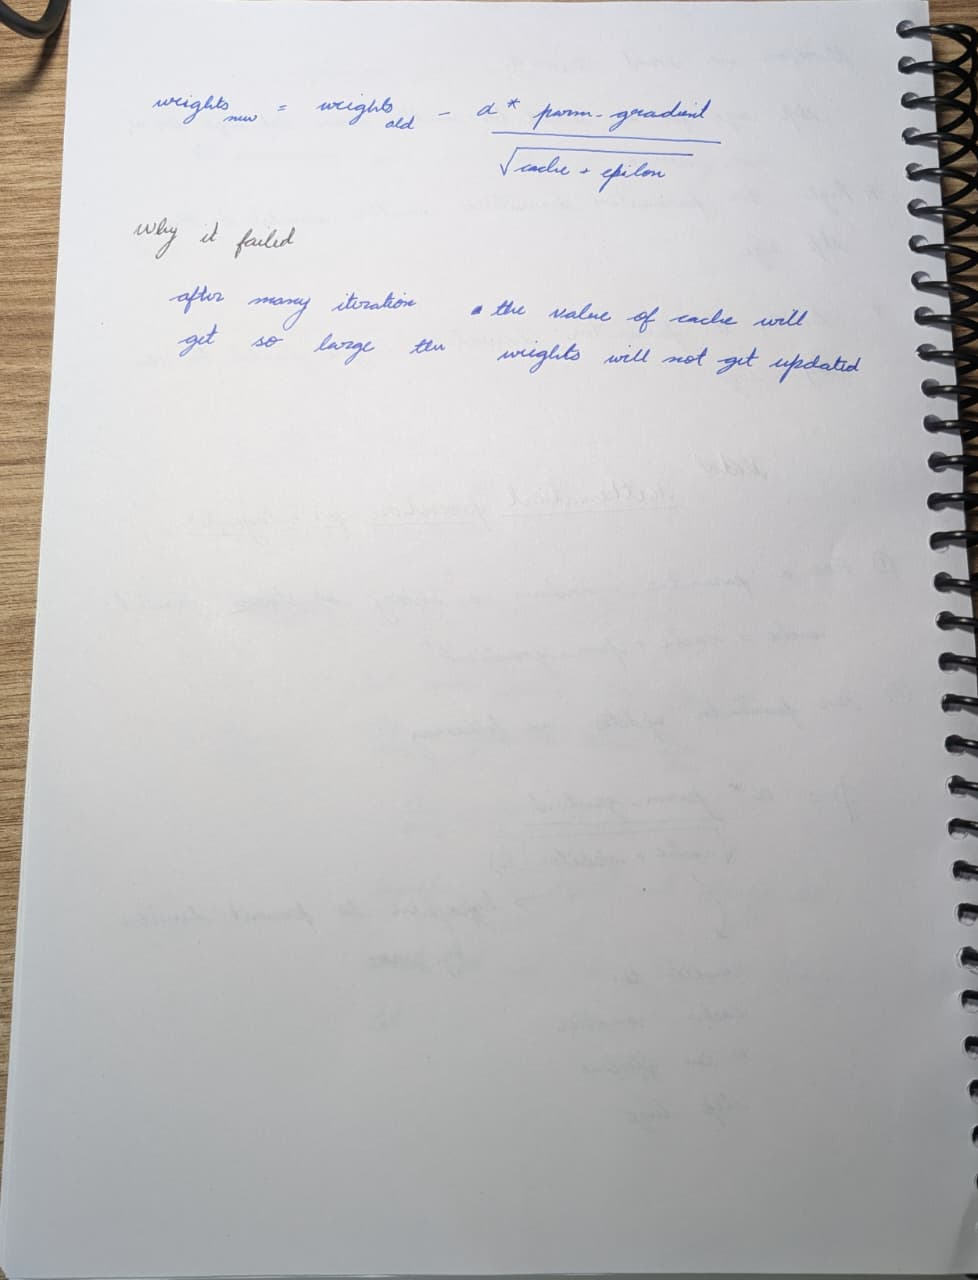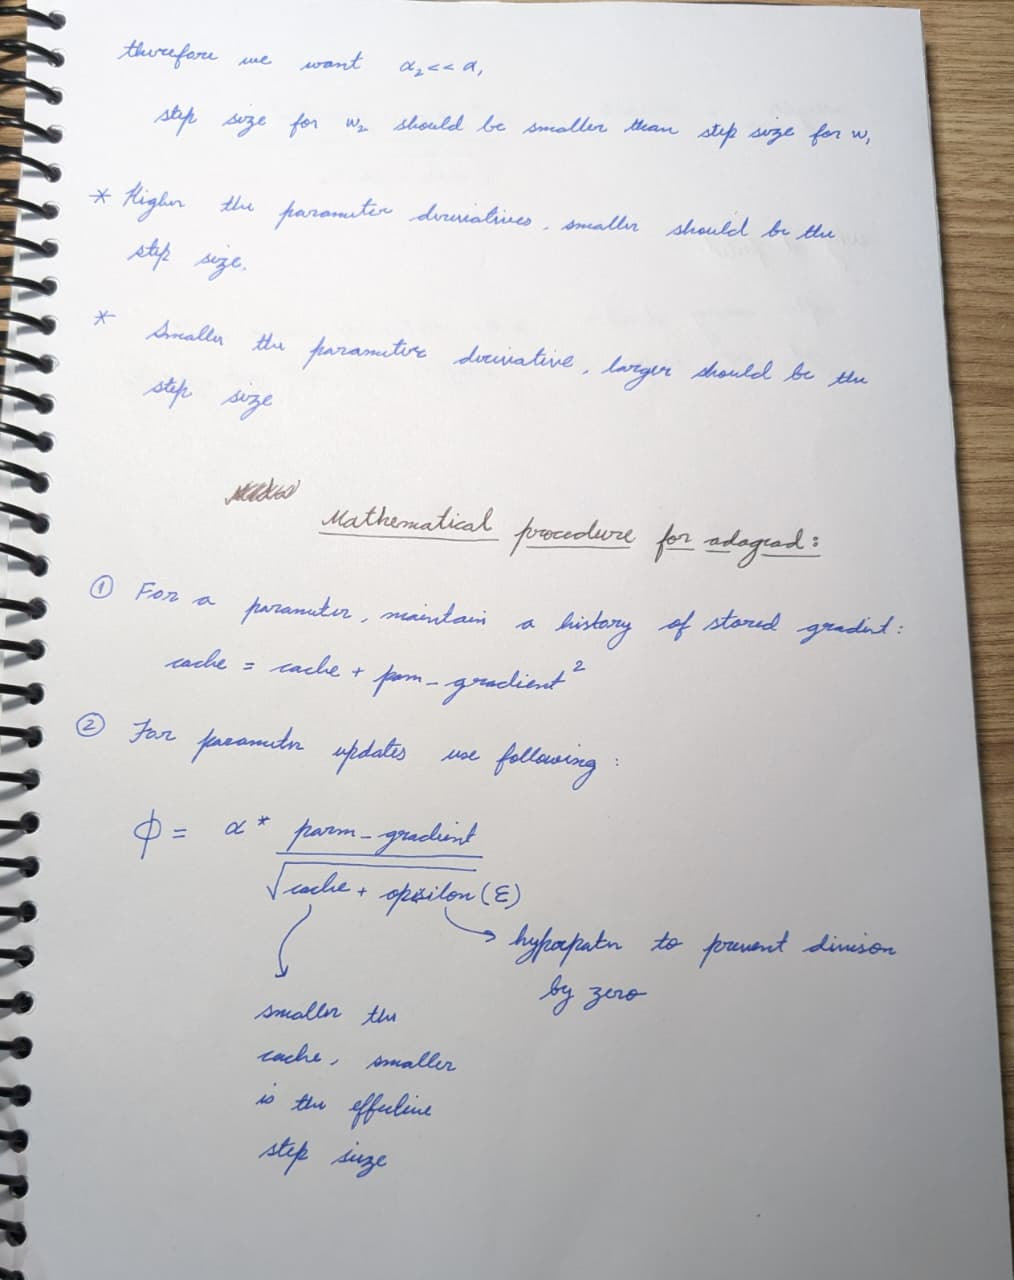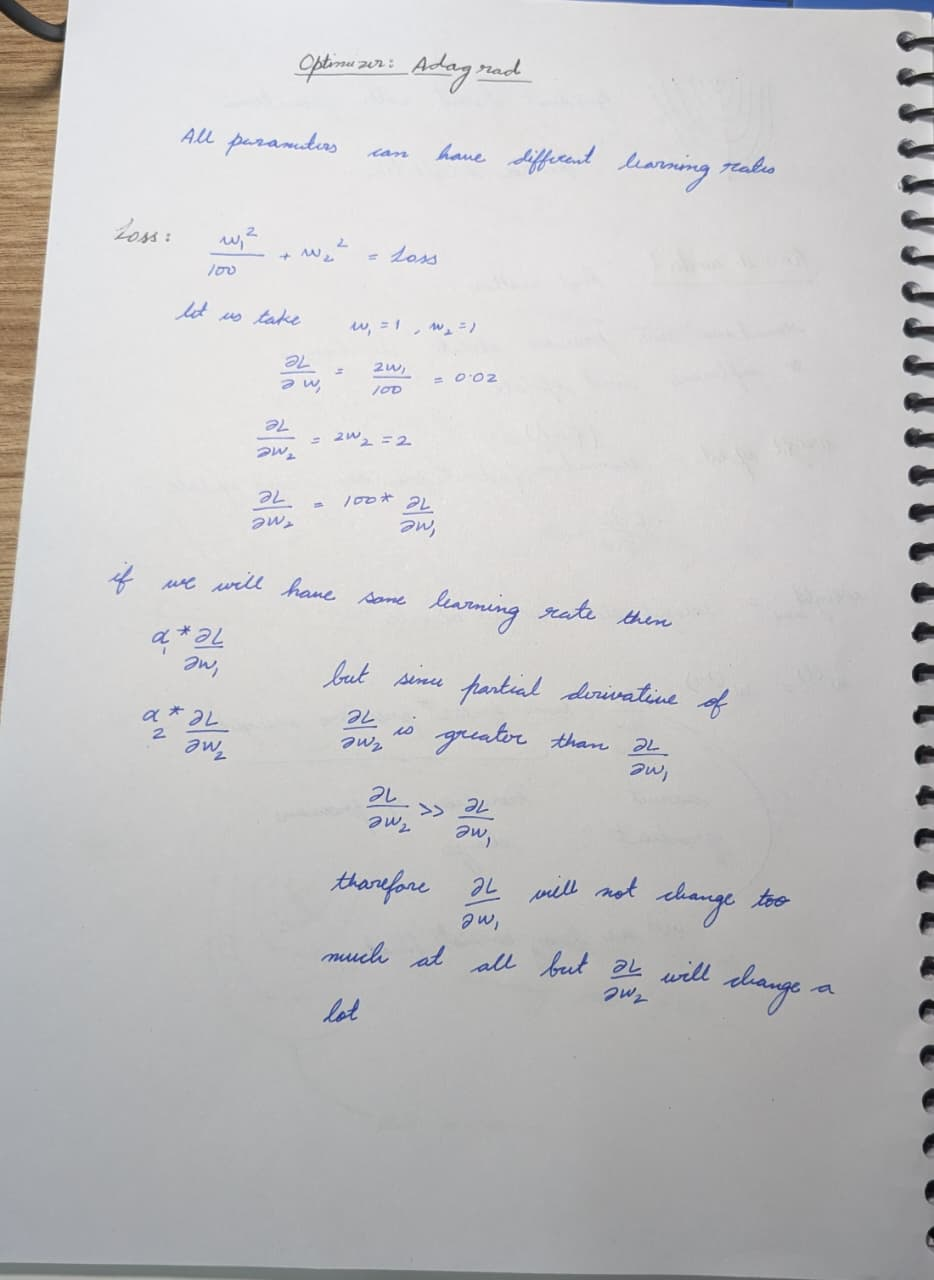

In [11]:
import numpy as np

# Adagrad optimizer
class Optimizer_Adagrad:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbias**2

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * \
            layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            layer.dbias / \
            (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [13]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Ensure y is a 1D array of class labels, if it's not already (spiral_data returns 1D)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
# optimizer = Optimizer_SGD(decay=8e-8, momentum=0.9)
optimizer = Optimizer_Adagrad(decay=1e-4)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    # Removed: if len(y.shape) == 2: y = np.argmax(y, axis=1) as y is already 1D
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.297, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.453, loss: 1.021, lr: 0.9901970492127933
epoch: 200, acc: 0.460, loss: 0.978, lr: 0.9804882831650161
epoch: 300, acc: 0.480, loss: 0.943, lr: 0.9709680551509855
epoch: 400, acc: 0.530, loss: 0.904, lr: 0.9616309260505818
epoch: 500, acc: 0.523, loss: 0.882, lr: 0.9524716639679969
epoch: 600, acc: 0.530, loss: 0.865, lr: 0.9434852344560807
epoch: 700, acc: 0.583, loss: 0.851, lr: 0.9346667912889054
epoch: 800, acc: 0.553, loss: 0.838, lr: 0.9260116677470135
epoch: 900, acc: 0.610, loss: 0.799, lr: 0.9175153683824203
epoch: 1000, acc: 0.623, loss: 0.777, lr: 0.9091735612328392
epoch: 1100, acc: 0.640, loss: 0.748, lr: 0.9009820704567978
epoch: 1200, acc: 0.643, loss: 0.728, lr: 0.892936869363336
epoch: 1300, acc: 0.657, loss: 0.712, lr: 0.8850340738118416
epoch: 1400, acc: 0.663, loss: 0.695, lr: 0.8772699359592947
epoch: 1500, acc: 0.683, loss: 0.683, lr: 0.8696408383337683
epoch: 1600, acc: 0.683, loss: 0.673, lr: 0.86214328